## IMPORTS and UTILS

In [1]:
print("hi")

import os
import pandas as pd
import subprocess
import re
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

import os

from robust_evaluation_tools.robust_utils import remove_covariates_effects
from robust_evaluation_tools.robust_harmonization import fit, apply, QC, compare_with_camcan, visualize_harmonization
from robust_evaluation_tools.robust_analysis import get_distribution_properties

metric = 'md'
harmonizartion_method = 'classic'
robust = 'No'
rwp = False
hc = False

HC_LABEL = 'HC'
disease = 'SYN'
bundle = 'mni_AC'


MAINFOLDER = "FAKE_SICK"

hi


In [2]:
def plot_df(df, bundle):
    df = df[df['bundle'] == bundle]
    plt.figure(figsize=(10, 6))
    plt.scatter(df[df['disease'] == HC_LABEL]['age'], df[df['disease'] == HC_LABEL]['mean'], color='blue', label='HC', alpha=0.5)
    plt.scatter(df[df['disease'] != HC_LABEL]['age'], df[df['disease'] != HC_LABEL]['mean'], color='red', label=f'{disease}', alpha=0.5)

    plt.title(f'Distribution of {disease} in metric {metric} for bundle: {bundle} (mean)')
    plt.xlabel('Age')
    plt.ylabel('Mean')
    plt.legend()
    plt.show()

    # Scatter plot with mean_no_cov
    plt.figure(figsize=(10, 6))
    plt.scatter(df[df['disease'] == HC_LABEL]['age'], df[df['disease'] == HC_LABEL]['mean_no_cov'], color='blue', label='HC', alpha=0.5)
    plt.scatter(df[df['disease'] != HC_LABEL]['age'], df[df['disease'] != HC_LABEL]['mean_no_cov'], color='red', label=f'{disease}', alpha=0.5)

    plt.title(f'Distribution of {disease} in metric {metric} for bundle: {bundle} (mean_no_cov)')
    plt.xlabel('Age')
    plt.ylabel('Mean_no_cov')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df['disease'] == HC_LABEL]['mean_no_cov'], color='blue', label='HC', fill=True)
    sns.kdeplot(df[df['disease'] != HC_LABEL]['mean_no_cov'], color='red', label=f'{disease}', fill=True)
    plt.title(f'Distribution of {disease} in metric {metric} for bundle: {bundle}')
    plt.xlabel('mean_no_cov')
    plt.ylabel('Frequency')
    plt.legend()

In [3]:
# Read the camCan md file
camCan_file = os.path.join('DONNES','CamCAN', f"CamCAN.{metric}.raw.csv.gz")
directory = os.path.join(MAINFOLDER, "HARMONIZATION")
os.makedirs(directory, exist_ok=True)

camCan = pd.read_csv(camCan_file)
# Randomly select 100 unique 'sid' values

biaised_camCan = camCan.copy()
biaised_camCan['mean'] += 0.0001

test_sids = np.random.choice(biaised_camCan['sid'].unique(), 100, replace=False)

# Create the test dataframe with the selected 'sid' values
test = biaised_camCan[biaised_camCan['sid'].isin(test_sids)]
test_file = os.path.join(directory, f"CamCAN_test.{metric}.raw.csv.gz")
test.to_csv(test_file, index=False)

# Remove the selected 'sid' values from the original camCan dataframe
biaised_camCan = biaised_camCan[~biaised_camCan['sid'].isin(test_sids)]

# Create an array of biases
biases = [0.00003, 0.00005, 0.0001]
camCan_copies = []
camCan_files_copies = []
for i, bias in enumerate(biases, start=1):
    camCan_copy = biaised_camCan.copy()
    camCan_copy['mean'] += bias
    camCan_copy['disease'] = disease
    camCan_copy['sid'] = camCan_copy['sid'].astype(str) + f'_{i}'
    camCan_copy = pd.concat([biaised_camCan, camCan_copy])
    camCan_copy = remove_covariates_effects(camCan_copy)
    camCan_copy['site'] = f'camCan_copy{i}'
    camCan_copies.append(camCan_copy)
    file = os.path.join(directory, f"CamCAN_sick_{i}.{metric}.raw.csv.gz")
    camCan_files_copies.append(file)
    camCan_copy.to_csv(file, index=False)


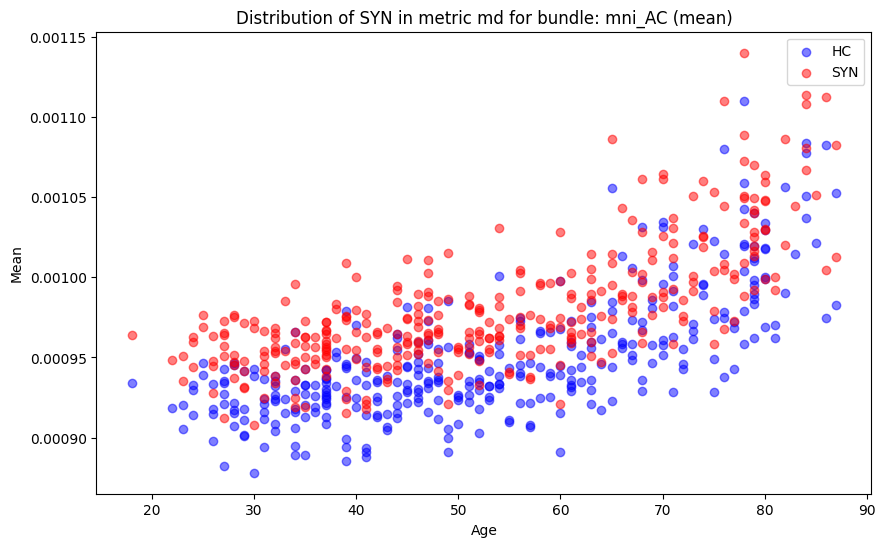

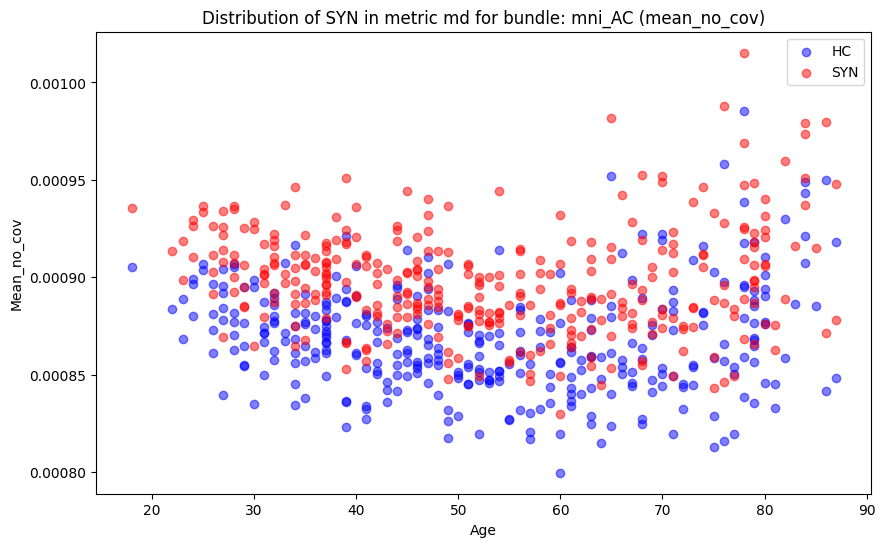

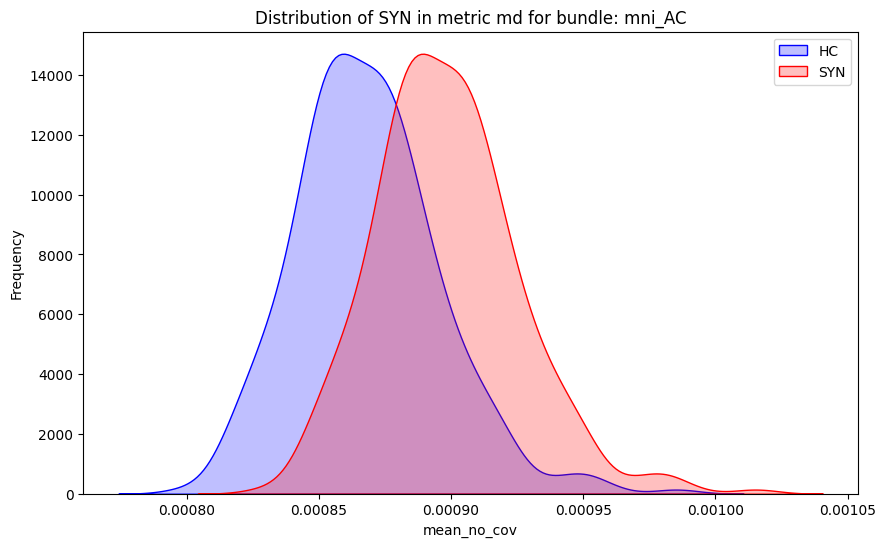

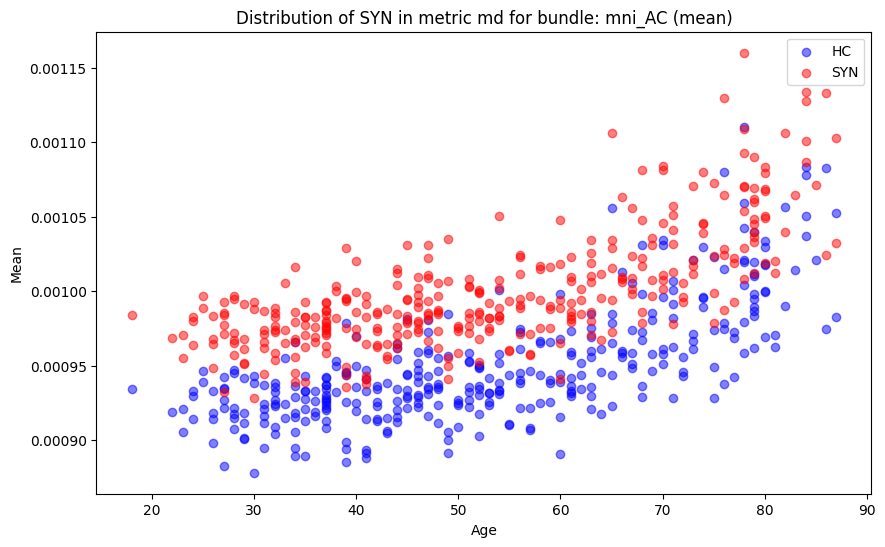

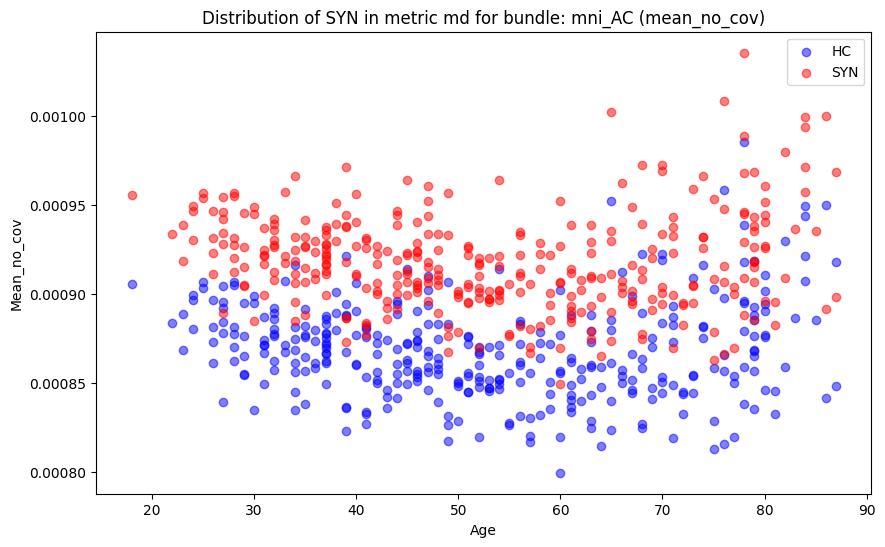

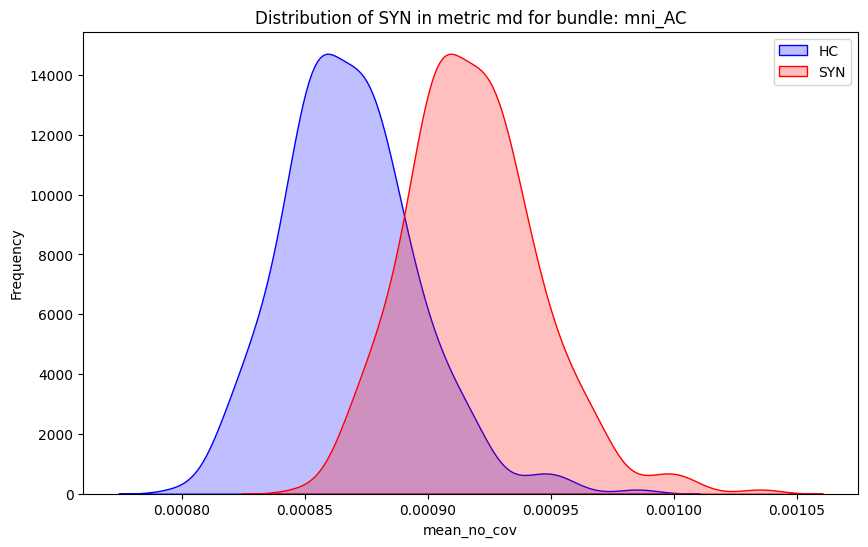

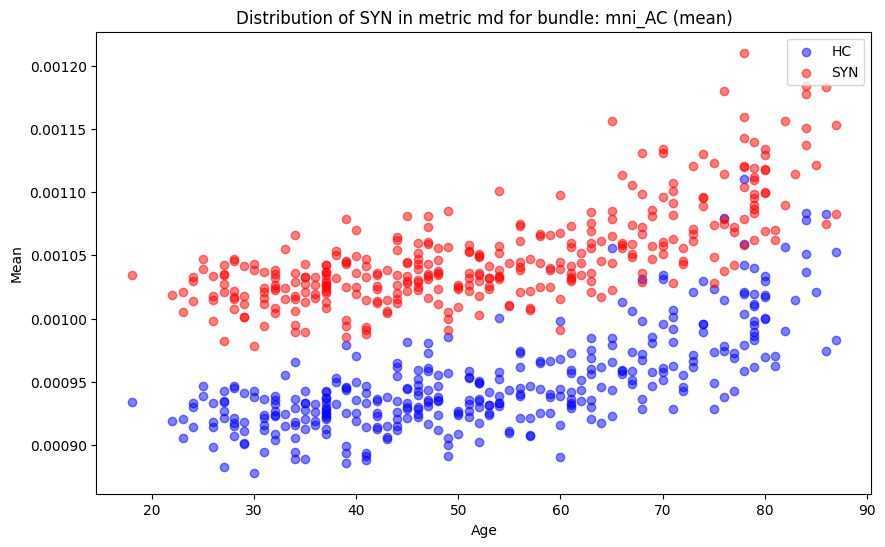

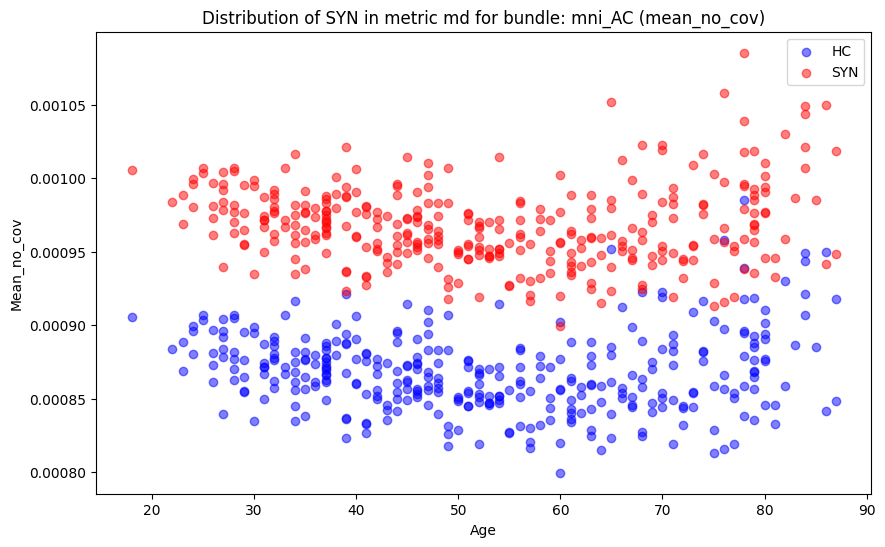

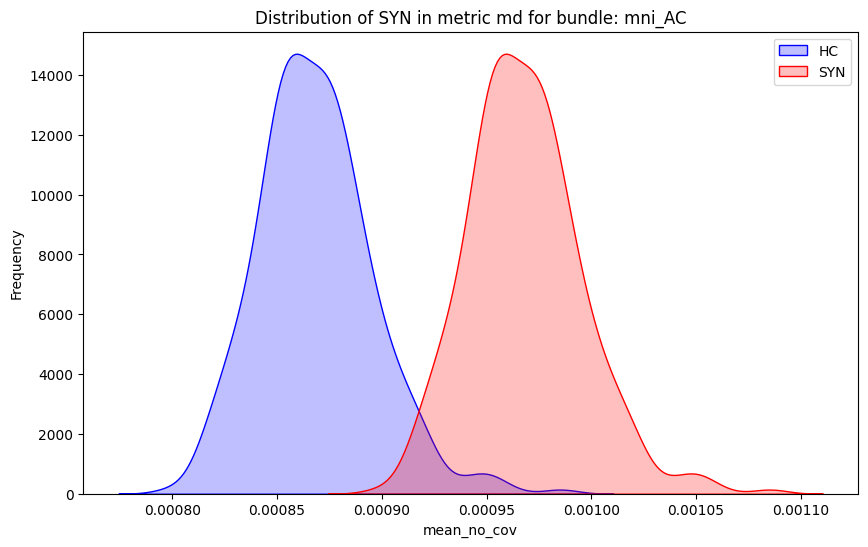

In [4]:
for camCan_copy in camCan_copies:
    plot_df(camCan_copy, bundle)

In [5]:
dir = os.path.join(directory, 'FULL_SITE')
os.makedirs(dir, exist_ok=True)
for copy_filename in camCan_files_copies:
    output_model_filename_sick_1 = fit(copy_filename, camCan_file, metric, harmonizartion_method, robust, rwp, dir, hc,)
    # Apply the model
    output_filename_sick_1 = apply(copy_filename, output_model_filename_sick_1, metric, harmonizartion_method, robust, rwp, dir)

    visualize_harmonization(copy_filename, output_filename_sick_1, camCan_file, dir, bundle)

In [6]:
def apply_fixed_number_of_sick(df,test_file, diff_sick, total ,proportion, metric, harmonizartion_method, robust, rwp, directory, hc, camCan_file, index):
    # Create a copy of the dataframe
    df_copy = df.copy()
    num_sick = int(proportion * total)
    num_healthy = total - num_sick
    
    # Separate healthy and sick samples
    healthy_samples = df_copy[df_copy['disease'] == HC_LABEL]
    sick_samples = df_copy[df_copy['disease'] != HC_LABEL] 
    
    selected_healthy_sids = np.random.choice(healthy_samples['sid'].unique(), num_healthy, replace=False)
    selected_sick_sids = np.random.choice(sick_samples['sid'].unique(), num_sick, replace=False)
    
    # Filter the dataframe to include only the selected samples
    df_selected = df_copy[df_copy['sid'].isin(selected_healthy_sids) | df_copy['sid'].isin(selected_sick_sids)]
    # Change the site of the selected samples
    df_selected['site'] = f'CamCAN_sick-{proportion}-{index}'
    
    # Save the modified dataframe to a file
    file_path = os.path.join(directory, f"CamCAN_sick_{proportion}_{index}.{metric}.raw.csv.gz")
    df_selected.to_csv(file_path, index=False)
    
    # Apply the fit function
    output_model_filename = fit(file_path, camCan_file, metric, harmonizartion_method, robust, rwp, directory, hc)
    
    # Apply the model
    output_filename = apply(file_path, output_model_filename, metric, harmonizartion_method, robust, rwp, directory)

    output_filename_test = apply(test_file, output_model_filename, metric, harmonizartion_method, robust, rwp, directory)


    res = compare_with_camcan(pd.read_csv(output_filename))
    res['site'] = f'CamCAN_sick{diff_sick}_{proportion}_{index}'
    res['disease_ratio'] = proportion
    res['index'] = index
    res['num_patients'] = total
    res['metric'] = metric
    res['method'] = 'train'

    res_test = compare_with_camcan(pd.read_csv(output_filename_test))
    res_test['site'] = f'CamCAN_sick{diff_sick}_{proportion}_{index}'
    res_test['disease_ratio'] = proportion
    res_test['index'] = index
    res_test['num_patients'] = total
    res_test['metric'] = metric
    res_test['method'] = 'test'

    distr_metrics = get_distribution_properties(df_selected)
    distr_metrics['site'] = f'CamCAN_sick{diff_sick}_{proportion}_{index}'
    distr_metrics['disease_ratio'] = proportion
    distr_metrics['index'] = index
    distr_metrics['num_patients'] = total
    distr_metrics['metric'] = metric
    distr_metrics['method'] = 'train'
    
    
    # Visualize the harmonization
    visualize_harmonization(file_path, output_filename, camCan_file, directory, bundle)

    return pd.concat([res, res_test]), distr_metrics



# Define the number of sick samples to test
total = 200

# Apply the function to the biaised_camCan dataframe
proportions = [0.0, 0.2, 0.3, 0.4, 0.6, 0.8]
total_mae = pd.DataFrame()
total_distr_metrics = pd.DataFrame()

for i, copie in enumerate(camCan_copies):
    dir = os.path.join(directory, "PROPORTION", f"CamCAN_sick_{i}")
    os.makedirs(dir, exist_ok=True)
    for proportion in proportions:
        for index in range(10):
            mae, distr_metrics = apply_fixed_number_of_sick(copie, test_file, i, total, proportion, metric, harmonizartion_method, robust, rwp, dir, hc, camCan_file, index)
            mae['diff_sick'] = i
            distr_metrics['diff_sick'] = i
            total_mae = pd.concat([total_mae, mae])
            total_distr_metrics = pd.concat([total_distr_metrics, distr_metrics])

/tmp/ipykernel_453447/119489054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['site'] = f'CamCAN_sick-{proportion}-{index}'
/tmp/ipykernel_453447/119489054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['site'] = f'CamCAN_sick-{proportion}-{index}'
/tmp/ipykernel_453447/119489054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [7]:
total_mae

,mni_AC,mni_AF_L,mni_AF_R,mni_AST_L,mni_AST_R,mni_CC,mni_CCMid,mni_CC_ForcepsMajor,mni_CC_ForcepsMinor,mni_CST_L,...,mni_UF_R,mni_VOF_L,mni_VOF_R,site,disease_ratio,index,num_patients,metric,method,diff_sick
0,8.489936e-07,8.507323e-07,5.843251e-07,0.000001,8.356830e-07,1.883310e-06,1.655028e-06,3.035546e-06,7.409689e-07,1.499665e-06,...,7.702880e-07,1.973901e-06,1.389918e-06,CamCAN_sick0_0.0_0,0.0,0,200,md,train,0
0,8.139526e-07,7.839889e-07,5.507660e-07,0.000001,8.071072e-07,1.585854e-06,1.422539e-06,2.691935e-06,7.500084e-07,1.405906e-06,...,8.121261e-07,1.768693e-06,1.322048e-06,CamCAN_sick0_0.0_0,0.0,0,200,md,test,0
0,1.100060e-06,1.573176e-06,1.026183e-06,0.000002,6.916877e-07,4.375594e-07,5.249362e-07,3.396048e-07,1.260372e-06,6.935947e-07,...,1.798306e-06,1.188334e-06,2.075894e-06,CamCAN_sick0_0.0_1,0.0,1,200,md,train,0
0,1.223248e-06,1.791715e-06,1.164607e-06,0.000002,7.442058e-07,4.969031e-07,4.921066e-07,3.094738e-07,1.424257e-06,6.567752e-07,...,1.940952e-06,1.437489e-06,2.651358e-06,CamCAN_sick0_0.0_1,0.0,1,200,md,test,0
0,1.010601e-06,1.723219e-06,1.853530e-06,0.000002,6.255824e-07,5.290226e-07,4.000246e-07,9.463153e-07,1.612667e-06,9.433182e-08,...,8.628754e-07,6.544577e-07,9.678402e-07,CamCAN_sick0_0.0_2,0.0,2,200,md,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,5.153251e-05,5.058756e-05,5.300121e-05,0.000054,5.166208e-05,5.191228e-05,5.310878e-05,5.976412e-05,5.486716e-05,4.610892e-05,...,5.005083e-05,5.546877e-05,5.286761e-05,CamCAN_sick2_0.8_7,0.8,7,200,md,test,2
0,4.516915e-05,4.202529e-05,4.487208e-05,0.000045,4.544560e-05,4.440425e-05,4.751317e-05,5.067269e-05,4.622281e-05,4.172828e-05,...,4.358272e-05,4.496490e-05,4.552446e-05,CamCAN_sick2_0.8_8,0.8,8,200,md,train,2
0,4.737850e-05,4.637536e-05,4.845380e-05,0.000049,4.858740e-05,4.799435e-05,5.040516e-05,5.432979e-05,4.956777e-05,4.467582e-05,...,4.592602e-05,4.989596e-05,4.948061e-05,CamCAN_sick2_0.8_8,0.8,8,200,md,test,2
0,4.404262e-05,4.433664e-05,4.707558e-05,0.000049,4.775233e-05,4.684240e-05,4.892559e-05,5.468250e-05,4.875882e-05,4.307740e-05,...,4.689798e-05,4.985603e-05,4.837761e-05,CamCAN_sick2_0.8_9,0.8,9,200,md,train,2


In [8]:
total_distr_metrics

,property,left_ventricle,mni_AC,mni_AF_L,mni_AF_R,mni_AST_L,mni_AST_R,mni_CC,mni_CCMid,mni_CC_ForcepsMajor,...,mni_VOF_L,mni_VOF_R,right_ventricle,site,disease_ratio,index,num_patients,metric,method,diff_sick
0,skewness,-0.513643,0.64588,1.004259,1.346352,0.839403,0.895104,0.958316,1.007219,0.826072,...,0.786111,0.488164,-0.37224,CamCAN_sick0_0.0_0,0.0,0,200,md,train,0
1,mean_median_shift,0.003913,0.001617,0.002258,0.002682,0.000811,0.004134,0.002813,0.004456,0.00501,...,0.006087,0.000538,0.009575,CamCAN_sick0_0.0_0,0.0,0,200,md,train,0
2,kurtosis,0.690929,1.160579,2.739176,5.250529,1.968491,1.659019,2.114056,2.413673,1.462377,...,1.707537,0.824035,0.096057,CamCAN_sick0_0.0_0,0.0,0,200,md,train,0
0,skewness,-0.655283,0.769197,1.168649,1.583084,0.953113,1.008795,1.165852,1.167536,0.925296,...,0.931239,0.690923,-0.368795,CamCAN_sick0_0.0_1,0.0,1,200,md,train,0
1,mean_median_shift,0.006061,0.001097,0.001249,0.002714,0.000481,0.005159,0.002966,0.003276,0.004263,...,0.003313,0.002135,0.010151,CamCAN_sick0_0.0_1,0.0,1,200,md,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,mean_median_shift,0.005115,0.009315,0.012333,0.011739,0.010843,0.010577,0.008407,0.008911,0.008598,...,0.012309,0.011747,0.007799,CamCAN_sick2_0.8_8,0.8,8,200,md,train,2
2,kurtosis,0.780045,0.253554,0.202192,0.284466,0.347634,0.437188,0.363089,0.525367,0.514969,...,0.601971,0.383963,0.287789,CamCAN_sick2_0.8_8,0.8,8,200,md,train,2
0,skewness,-0.406794,-0.795898,-0.800244,-0.795062,-0.741283,-0.72095,-0.744665,-0.64745,-0.410212,...,-0.426133,-0.697599,-0.353479,CamCAN_sick2_0.8_9,0.8,9,200,md,train,2
1,mean_median_shift,0.005161,0.01032,0.012476,0.009981,0.010159,0.010818,0.009259,0.009992,0.006557,...,0.007085,0.011969,0.00027,CamCAN_sick2_0.8_9,0.8,9,200,md,train,2


In [9]:
# CREATION BOX PLOT POUR MEA
def plot_mea(df, sample_size, diff_sick, metric, directory):
    """
    Crée un graphique pour chaque bundle dans le DataFrame donné.
    L'axe des X représente le nombre de patients et l'axe des Y représente la moyenne de la colonne du bundle.
    La courbe inclut une zone indiquant l'écart-type (std).

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    bundle_column (str): Le nom de la colonne du bundle à utiliser pour le graphique.
    """
    directory = os.path.join(directory, "MEA_PLOTS", str(diff_sick), metric, str(sample_size))
    df = df[df['num_patients'] == sample_size]
    df = df[df['diff_sick'] == diff_sick]
    df = df[df['metric'] == metric]
    os.makedirs(directory, exist_ok=True)
    
    for bundle_column in df.columns:
        if bundle_column in ['site','num_patients','disease_ratio', 'metric', 'diff_sick', 'method', 'index']:
            continue # Skip non-numeric columns
        bundle_df = df[[bundle_column, 'site' ,'index','disease_ratio','diff_sick', 'method']].copy()
        methods = ["train", "test"]
        colors = ['green', 'red']
        
        plt.figure(figsize=(10, 5))
        width = 0.2  # the width of the bars
        x = np.arange(len(bundle_df['disease_ratio'].unique()))  # the label locations
        fig, ax = plt.subplots(figsize=(10, 5))

        for i, (method, color) in enumerate(zip(methods, colors)):
            method_df = bundle_df[bundle_df['method'] == method]
            data = [method_df[method_df['disease_ratio'] == patients][bundle_column].values 
                    for patients in bundle_df['disease_ratio'].unique()]
            
            # Ensure there is data for each num_patients
            if any(len(d) > 0 for d in data):
                positions = x + i * width  # Shift positions for each method
                ax.boxplot(data, positions=positions, widths=0.15, patch_artist=True, 
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color='black'))
                
        ax.set_xlabel('Prct de patients malades')
        ax.set_ylabel('MAE')
        ax.set_title(f'MAE Maladie: {diff_sick} bundle: {bundle_column}, metrique : {metric} avec {sample_size} patients')
        ax.set_xticks(x + width * (len(methods) - 1) / 2)
        ax.set_xticklabels(bundle_df['disease_ratio'].unique())
        ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=f'Method: {method}') for method, color in zip(methods, colors)])
        plt.savefig(os.path.join(directory, f'{bundle_column}_boxplot.png'))
        plt.close()

sample_sizes = [200]

for diff_sick in total_mae['diff_sick'].unique():
    for sample_size in sample_sizes:
        plot_mea(total_mae, sample_size, diff_sick, 'md', directory)

/tmp/ipykernel_453447/1559024932.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))
/tmp/ipykernel_453447/1559024932.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [11]:
# CREATION BOX PLOT POUR property
def plot_properties(df, property, sample_size, diff_sick, metric, directory):
    """
    Crée un graphique pour chaque bundle dans le DataFrame donné.
    L'axe des X représente le nombre de patients et l'axe des Y représente la moyenne de la colonne du bundle.
    La courbe inclut une zone indiquant l'écart-type (std).

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    bundle_column (str): Le nom de la colonne du bundle à utiliser pour le graphique.
    """
    directory = os.path.join(directory, "PROPERTIES_PLOTS", str(diff_sick), property, metric, str(sample_size))
    df = df[df['property'] == property]
    df = df[df['num_patients'] == sample_size]
    df = df[df['diff_sick'] == diff_sick]
    df = df[df['metric'] == metric]
    os.makedirs(directory, exist_ok=True)
    
    for bundle_column in df.columns:
        if bundle_column in ['site','num_patients','disease_ratio', 'metric', 'diff_sick', 'method', 'index', 'property']:
            continue # Skip non-numeric columns
        bundle_df = df[[bundle_column, 'site' ,'index','disease_ratio','diff_sick', 'method']].copy()
        methods = ["test"]
        colors = ['green']
        
        plt.figure(figsize=(10, 5))
        width = 0.2  # the width of the bars
        x = np.arange(len(bundle_df['disease_ratio'].unique()))  # the label locations
        fig, ax = plt.subplots(figsize=(10, 5))

        for i, (method, color) in enumerate(zip(methods, colors)):
            method_df = bundle_df[bundle_df['method'] == method]
            data = [method_df[method_df['disease_ratio'] == patients][bundle_column].values 
                    for patients in bundle_df['disease_ratio'].unique()]
            
            # Ensure there is data for each num_patients
            if any(len(d) > 0 for d in data):
                positions = x + i * width  # Shift positions for each method
                ax.boxplot(data, positions=positions, widths=0.15, patch_artist=True, 
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color='black'))
                
        ax.set_xlabel('Prct de patients malades')
        ax.set_ylabel(property)
        ax.set_title(f'{property} Maladie: {diff_sick} bundle: {bundle_column}, metrique : {metric} avec {sample_size} patients')
        ax.set_xticks(x + width * (len(methods) - 1) / 2)
        ax.set_xticklabels(bundle_df['disease_ratio'].unique())
        ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=f'Method: {method}') for method, color in zip(methods, colors)])
        plt.savefig(os.path.join(directory, f'{bundle_column}_boxplot.png'))
        plt.close()

sample_sizes = [200]
total_distr_metrics
#Stotal_distr_metrics['diff_sick'] = [0] * 360 + [1] * 360 + [2] * 360
for diff_sick in total_distr_metrics['diff_sick'].unique():
    for property in total_distr_metrics['property'].unique():
        for sample_size in sample_sizes:
            plot_properties(total_distr_metrics, property, sample_size, diff_sick, 'md', directory)

/tmp/ipykernel_453447/1541624602.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 5))
/tmp/ipykernel_453447/1541624602.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [12]:
combined_df = pd.merge(total_distr_metrics, total_mae, on=['site', 'metric', 'disease_ratio', 'index', 'diff_sick'], suffixes=('_distr', '_mae'))
combined_df


,property,left_ventricle,mni_AC_distr,mni_AF_L_distr,mni_AF_R_distr,mni_AST_L_distr,mni_AST_R_distr,mni_CC_distr,mni_CCMid_distr,mni_CC_ForcepsMajor_distr,...,mni_SLF_L_mae,mni_SLF_R_mae,mni_STT_L_mae,mni_STT_R_mae,mni_UF_L_mae,mni_UF_R_mae,mni_VOF_L_mae,mni_VOF_R_mae,num_patients_mae,method_mae
0,skewness,-0.513643,0.64588,1.004259,1.346352,0.839403,0.895104,0.958316,1.007219,0.826072,...,0.000002,0.000001,0.000003,0.000003,9.430706e-07,7.702880e-07,0.000002,0.000001,200,train
1,skewness,-0.513643,0.64588,1.004259,1.346352,0.839403,0.895104,0.958316,1.007219,0.826072,...,0.000002,0.000001,0.000003,0.000003,9.326935e-07,8.121261e-07,0.000002,0.000001,200,test
2,mean_median_shift,0.003913,0.001617,0.002258,0.002682,0.000811,0.004134,0.002813,0.004456,0.00501,...,0.000002,0.000001,0.000003,0.000003,9.430706e-07,7.702880e-07,0.000002,0.000001,200,train
3,mean_median_shift,0.003913,0.001617,0.002258,0.002682,0.000811,0.004134,0.002813,0.004456,0.00501,...,0.000002,0.000001,0.000003,0.000003,9.326935e-07,8.121261e-07,0.000002,0.000001,200,test
4,kurtosis,0.690929,1.160579,2.739176,5.250529,1.968491,1.659019,2.114056,2.413673,1.462377,...,0.000002,0.000001,0.000003,0.000003,9.430706e-07,7.702880e-07,0.000002,0.000001,200,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,skewness,-0.406794,-0.795898,-0.800244,-0.795062,-0.741283,-0.72095,-0.744665,-0.64745,-0.410212,...,0.000050,0.000052,0.000057,0.000061,4.703309e-05,4.762465e-05,0.000052,0.000051,200,test
1076,mean_median_shift,0.005161,0.01032,0.012476,0.009981,0.010159,0.010818,0.009259,0.009992,0.006557,...,0.000046,0.000050,0.000057,0.000061,4.573781e-05,4.689798e-05,0.000050,0.000048,200,train
1077,mean_median_shift,0.005161,0.01032,0.012476,0.009981,0.010159,0.010818,0.009259,0.009992,0.006557,...,0.000050,0.000052,0.000057,0.000061,4.703309e-05,4.762465e-05,0.000052,0.000051,200,test
1078,kurtosis,0.638674,0.131399,0.261303,0.085362,0.278803,0.134406,0.135979,0.198847,0.390156,...,0.000046,0.000050,0.000057,0.000061,4.573781e-05,4.689798e-05,0.000050,0.000048,200,train


In [13]:
correlation_df = pd.DataFrame(columns=['bundle', 'diff_sick', 'property', 'correlation'])
# Create scatter plots for each bundle, diff_sick, and property
for property in combined_df['property'].unique():
    df_property_filtered = combined_df[combined_df['property'] == property]
    for diff_sick in df_property_filtered['diff_sick'].unique():
        df_filtered = df_property_filtered[df_property_filtered['diff_sick'] == diff_sick]
        for bundle in total_mae.columns:
            if bundle in ['site', 'metric', 'disease_ratio', 'index', 'diff_sick', 'method', 'num_patients', 'property']:
                continue  # Skip non-numeric columns

            plt.figure(figsize=(10, 6))
            for method, color in zip(['train', 'test'], ['red', 'blue']):
                method_filtered = df_filtered[df_filtered['method_mae'] == method]
                plt.scatter(method_filtered[f'{bundle}_distr'], method_filtered[f'{bundle}_mae'], alpha=0.5, label=method, color=color)
            
            # Calculate correlation
            correlation = df_filtered[[f'{bundle}_distr', f'{bundle}_mae']].corr().iloc[0, 1]
            plt.title(f'Scatter plot for {bundle} (diff_sick: {diff_sick}, property: {property})\nCorrelation: {correlation:.2f}')
            plt.xlabel(f'{bundle} {property}')
            plt.ylabel(f'{bundle} MAE')
            plt.legend()
            plt.grid(True)
            
            # Create directory path
            directory = os.path.join(MAINFOLDER, 'PROPERTY_SCATTER' ,  f'{property}', f'diff_sick_{diff_sick}')
            os.makedirs(directory, exist_ok=True)
            
            # Save the plot
            plt.savefig(os.path.join(directory, f'scatter_plot_{bundle}.png'))
            plt.close()
            
            # Store correlation in a new dataframe
            new_row = pd.DataFrame({'bundle': [bundle], 'diff_sick': [diff_sick], 'property': [property], 'correlation': [correlation]})
            correlation_df = pd.concat([correlation_df, new_row], ignore_index=True)

/tmp/ipykernel_453447/2214966067.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df = pd.concat([correlation_df, new_row], ignore_index=True)


In [14]:
correlation_df['abs_correlation'] = correlation_df['correlation'].abs()
correlation_df = correlation_df.sort_values(by='abs_correlation', ascending=False)
correlation_df

,bundle,diff_sick,property,correlation,abs_correlation
87,mni_AF_L,2,skewness,-0.924328,0.924328
121,mni_SLF_L,2,skewness,-0.909175,0.909175
89,mni_AST_L,2,skewness,-0.906217,0.906217
88,mni_AF_R,2,skewness,-0.905478,0.905478
106,mni_IIT_mask_skeletonFA,2,skewness,-0.902191,0.902191
...,...,...,...,...,...
282,mni_ML_L,0,kurtosis,-0.005330,0.005330
264,mni_CCMid,0,kurtosis,0.005322,0.005322
58,mni_F_L_R,1,skewness,0.004650,0.004650
154,mni_ML_R,0,mean_median_shift,0.004389,0.004389
